## PCA를 통한 주식 시장 분석 

### KOSPI200 종목 data 를 sklearn.decomposition 을 통해 PCA 분석

PCA는 데이터의 차원 축소를 위해 사용되며, 데이터의 가장 큰 분산을 나타내는 주성분을 찾습니다. 이 방법은 고차원 데이터에서 패턴을 찾는 데 유용합니다. 이는 주식 시장에서도 유용하며, PCA를 주식 수익률에 적용하면 첫 번째 주성분이 시장 요인에 근사하게 됩니다. 이는 첫 번째 주성분이 전체 주식 시장의 변동을 가장 잘 설명하기 때문입니다.

In [1]:
import os
import os.path
import numpy as np
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import FinanceDataReader as fdr
import pandas_datareader as data_reader
from sklearn.decomposition import PCA
import korean

In [2]:
# 코스피200 ticker 및 지수 가져오기
with open('./data/kospi200tickers.pickle', 'rb') as f:
    tickers = pickle.load(f)   

- `{ticker: name}` dictionary  작성

In [3]:
ticker_to_name = {}

for ticker in tickers:
    ticker_to_name[ticker[0]] = ticker[1]
    
list(ticker_to_name.items())[:5]

[('005930', '삼성전자'),
 ('000660', 'SK하이닉스'),
 ('035420', 'NAVER'),
 ('207940', '삼성바이오로직스'),
 ('035720', '카카오')]

2020-01-01 ~ 2020-12-31 기간 KOSPI200 종목의 주가 정보 수집

In [4]:
%%time
main_df = pd.DataFrame()
start = '2020-01-01'
end = '2021-01-01'

for ticker in tickers:
    df = fdr.DataReader(ticker[0], start=start, end=end)
    df.rename(columns={'Close': ticker[1]}, inplace=True)
    main_df =  pd.concat([main_df, df[ticker[1]]], axis=1)
            
print(main_df.shape)
main_df.head()

(248, 200)
Wall time: 1min 10s


,삼성전자,SK하이닉스,NAVER,삼성바이오로직스,카카오,LG화학,삼성SDI,현대차,기아,카카오뱅크,...,동원F&B,LX홀딩스,넥센타이어,쿠쿠홀딩스,SNT모티브,삼양식품,현대두산인프라코어,롯데하이마트,일양약품,LX하우시스
2020-01-02 00:00:00,55200,94700,182500,423485,30609,314000,232000,118000,42500,NaN,...,44743,NaN,8900,20700,43600,89100,4655,30600,22850,54900
2020-01-03 00:00:00,55500,94500,181500,417061,30609,311000,229000,116000,42000,NaN,...,44543,NaN,8950,20900,43550,92600,4646,30400,22650,55500
2020-01-06 00:00:00,55500,94300,180500,407178,31010,307000,230000,116000,41900,NaN,...,43642,NaN,8890,20500,42400,92400,4494,29500,21850,54600
2020-01-07 00:00:00,55800,94000,187000,414096,32114,311000,231500,115500,42050,NaN,...,44042,NaN,8790,20600,42650,98000,4460,30100,22000,55900
2020-01-08 00:00:00,56800,97400,183000,403719,32014,302000,229000,112000,41300,NaN,...,43942,NaN,8560,20700,40800,97400,4266,28600,20650,53900


### null data cleansing  
- start 일 이후 상장한 종목이 있으므로 이전 날짜는 back fill 로 채움 
- 전체가 NaN (기간 중 상장 않은 종목)인 종목은 drop

In [5]:
# 한 개 이상의 결측값을 가진 열
main_df.loc[:, main_df.isnull().sum() > 0]

,카카오뱅크,크래프톤,SK바이오사이언스,하이브,SK아이이테크놀로지,SK바이오팜,DL이앤씨,LX홀딩스
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-12-23,NaN,NaN,NaN,151470.0,NaN,171000.0,NaN,NaN
2020-12-24,NaN,NaN,NaN,156420.0,NaN,171000.0,NaN,NaN
2020-12-28,NaN,NaN,NaN,154935.0,NaN,167500.0,NaN,NaN
2020-12-29,NaN,NaN,NaN,156915.0,NaN,168000.0,NaN,NaN


In [6]:
# main_df 데이터프레임의 복사본을 prices 변수에 할당합니다.
prices = main_df.copy()

# "bfill" 방식 - 결측값이 있는 위치의 바로 다음 행의 값으로 결측값을 대체
prices.fillna(method="bfill", inplace=True)

# "bfill"로 모든 결측값을 채웠다면, 이후에는 결측값이 없어야 합니다.
# 그래도 있는 경우 전체가 결측값인 경우 입니다.
prices.loc[:, prices.isnull().sum() > 0]

,카카오뱅크,크래프톤,SK바이오사이언스,SK아이이테크놀로지,DL이앤씨,LX홀딩스
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-12-23,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-24,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-28,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-29,NaN,NaN,NaN,NaN,NaN,NaN


전체가 NaN인 종목은 drop

In [7]:
prices.dropna(axis=1, inplace=True)
prices.shape

(248, 194)

## 모든 kospi200 종목의 daily Return(일일 수익률) 계산 

- 주가 크기가 서로 다르므로 log 함수 적용 
- log 를 적용했으므로 pct_change() 대신 diff() 적용

In [8]:
all_returns = prices.apply(np.log).diff(1)
all_returns.fillna(0, inplace=True)
all_returns.head(3)

,삼성전자,SK하이닉스,NAVER,삼성바이오로직스,카카오,LG화학,삼성SDI,현대차,기아,셀트리온,...,현대홈쇼핑,동원F&B,넥센타이어,쿠쿠홀딩스,SNT모티브,삼양식품,현대두산인프라코어,롯데하이마트,일양약품,LX하우시스
2020-01-02 00:00:00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-03 00:00:00,0.00542,-0.002114,-0.005495,-0.015286,0.000000,-0.009600,-0.013015,-0.017094,-0.011834,-0.013992,...,0.009975,-0.004480,0.005602,0.009615,-0.001147,0.038530,-0.001935,-0.006557,-0.008791,0.010870
2020-01-06 00:00:00,0.00000,-0.002119,-0.005525,-0.023982,0.013016,-0.012945,0.004357,0.000000,-0.002384,-0.025673,...,-0.028951,-0.020435,-0.006726,-0.019324,-0.026761,-0.002162,-0.033263,-0.030052,-0.035959,-0.016349


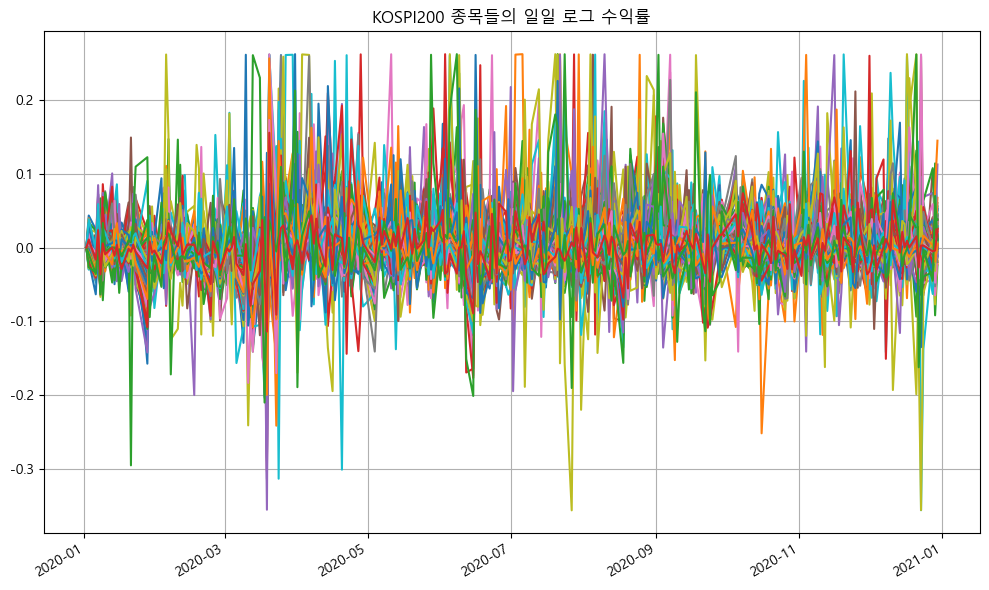

In [10]:
all_returns.plot(title="KOSPI200 종목들의 일일 로그 수익률", legend=False, 
             figsize=(10,6), grid=True);
plt.tight_layout()

- 누적 수익률 계산  
- log 수익률이므로 prod() 대신 cumsum()으로 더해줌  
- 원래의 값으로 복원하려면 np.exp() 적용

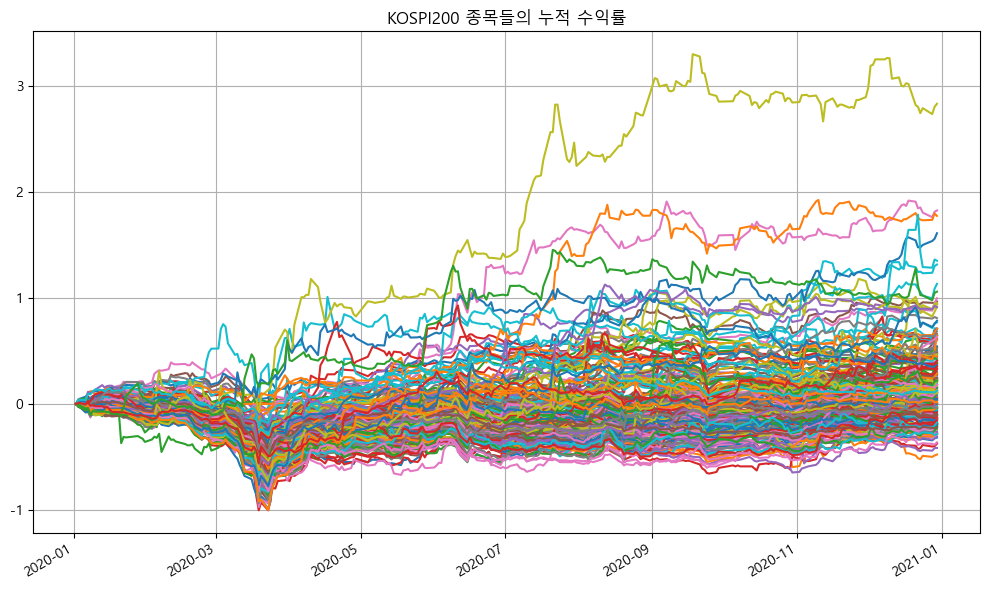

In [12]:
crs = all_returns.cumsum()#.apply(np.exp)

crs.plot(title="KOSPI200 종목들의 누적 수익률", legend=False,
         figsize=(10,6), grid=True)
plt.tight_layout()

위의 수치는 2020년  이후 KOSPI200 지수 200개 종목의 일일 수익률과 누적 수익률을 보여줍니다. 원시 데이터의 양이 상당히 많아 보일 수 있으므로 PCA를 통해 일일 수익률의 첫 번째 주성분을 계산하여 처리해 보겠습니다.

아래 그림은 기본적으로 200개 주식 각각에 대한 값을 포함하는 차원 200의 벡터인 첫 번째 주성분의 값을 보여줍니다.

In [15]:
# PCA 알고리즘을 이용해 주성분 1개를 추출합니다.
# 이 과정에서는 누락된 값을 0으로 대체합니다.
pca = PCA(n_components=1)
pca.fit(all_returns)

# 주성분 분석 결과를 시리즈로 변환
# 이 때, index는 원본 수익률 데이터의 컬럼명(즉, 주식의 종목명)을 사용
# data는 추출된 주성분의 값들을 사용
pc1 = pd.Series(index=all_returns.columns, data=pca.components_[0])

# 가중치를 절대값으로 변환하고 정규화
weights = abs(pc1) / sum(abs(pc1))
weights

삼성전자         0.003855
SK하이닉스       0.004267
NAVER        0.002607
삼성바이오로직스     0.003447
카카오          0.002848
               ...   
삼양식품         0.003103
현대두산인프라코어    0.005924
롯데하이마트       0.005925
일양약품         0.004062
LX하우시스       0.004989
Length: 194, dtype: float64

첫 번째 주성분은 대부분의 분산을 설명하는 입력 데이터의 선형 조합을 나타내고, 주식 수익률의 주요 동인은 전체 시장 요인이므로, 첫 번째 주성분(즉, 입력 데이터의 선형 결합)에 비례하여 현금을 할당해 주식 포트폴리오를 구성하면 KOSPI200의 수익률을 대략적으로 복제할 수 있음을 의미합니다.

In [17]:
pca_daily_return = (weights * all_returns).sum(axis=1)
pca_daily_return

2020-01-02    0.000000
2020-01-03   -0.000369
2020-01-06   -0.018791
2020-01-07    0.008515
2020-01-08   -0.028819
                ...   
2020-12-23    0.000121
2020-12-24    0.010099
2020-12-28   -0.002206
2020-12-29    0.004013
2020-12-30    0.014369
Length: 248, dtype: float64

portfolio의 누적 수익률

<Axes: >

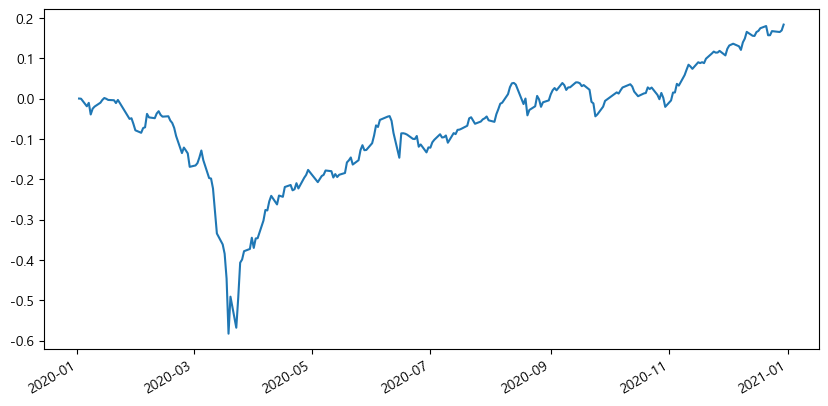

In [18]:
pca_daily_return.cumsum().plot()

아래 그림은 PCA 첫번째 주성분 portfolio가 KOSPI200을 거의 비슷하게 복제함을 보여줍니다.

In [19]:
# KOSPI200 지수 데이터를 받아옵니다.
kospi200 = fdr.DataReader('KS200', start=start, end=end)

# KOSPI200 지수의 일별 로그 수익률을 구합니다.
kospi200 = kospi200.apply(np.log).diff()

<Axes: >

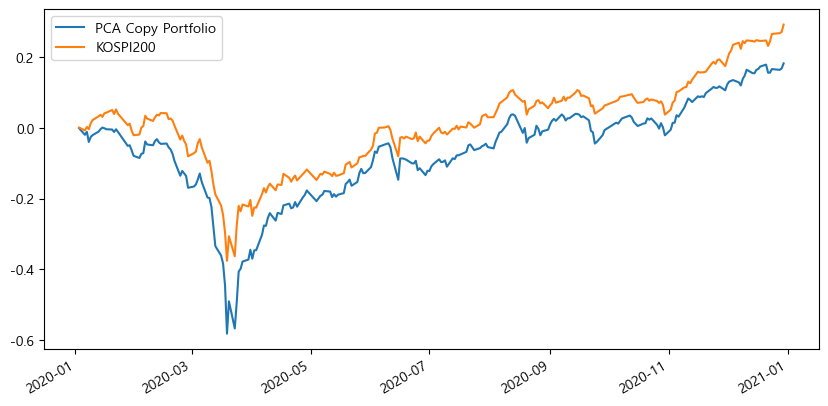

In [20]:
# PCA 포트폴리오의 수익률과 KOSPI200 지수의 수익률을 하나의 데이터프레임으로 합칩니다.
rs_df = pd.concat([pca_daily_return, kospi200['Close']], axis=1)
# 각 열의 이름을 설정합니다.
rs_df.columns = ["PCA Copy Portfolio", "KOSPI200"]
# 결측치를 제거한 후 누적 합을 계산하여 누적 수익률을 얻습니다.
rs_df = rs_df.dropna().cumsum()

rs_df.plot()